1.	Getting the data:
#  Services
*   In the Data Explorer, input the following parameters. All columns are found on the “Service” Table.
*   Click “Show Me”
*   Then wait and download the file.
*   Lastly, go into the file and convert to .csv for quicker read times in Python

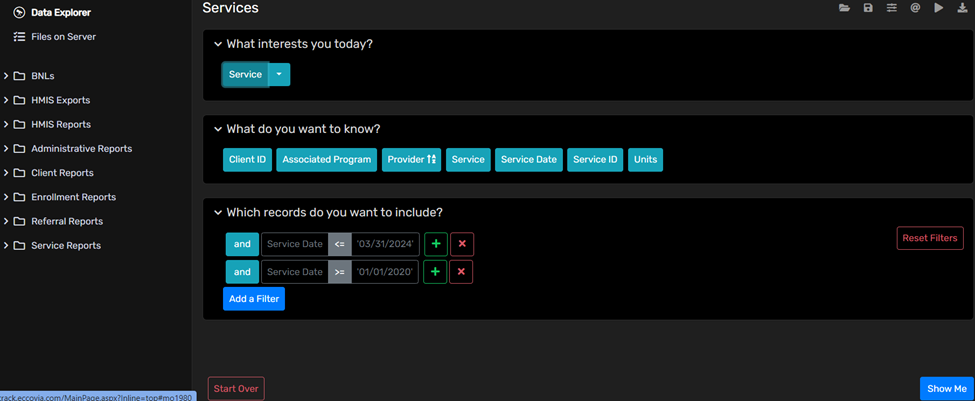


#  Exits
*   In the Data Explorer, input the following parameters. All columns are found on the “HMIS Enrollments (HSN)” Table.
*   Click “Show Me”
*   Then wait and download the file.
*   Lastly, go into the file and convert to .csv for quicker read times in Python

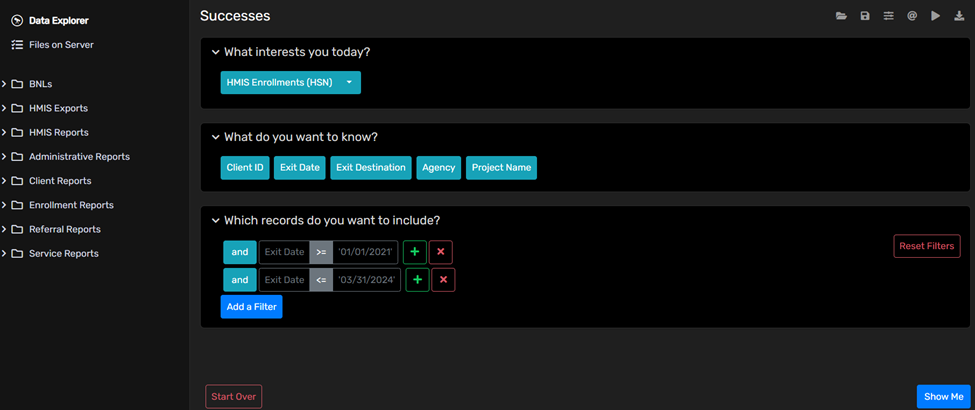

In [ ]:
import pandas as pd
import datetime as dt

'''
Timeframe: Jan 1, 2021 - March 31, 2024



-Total of unduplicated clients served?



-How many clients received laundry services?

—# laundry service entry count

—# total laundry unit count

—# unduplicated count

—# individuals in family count



-After receiving a laundry service, how many took the “next step” to ending their homelessness?

—“Next Step” services can include:

Career Counseling, Case Management, Criminal Justice/Legal Services, Disability Benefits, Education, Employment, Financial Counseling, Food Stamps/SNAP Benefits, Health Care Benefits, Housing Application Fee, Income Assistance, Job Search Assistance, Mail Access, Mental Health Care/Counseling, Moving Costs, Other Benefits Assistance, Permanent Housing, Problem Solving/Diversion/Rapid Rehousing, Resume Assistance, Social Security Benefits, Substance Abuse Counseling, Substance Use Treatment, Unemployment Benefits, Utility Deposit, Veterans Benefits



-After receiving a laundry service, how many transitioned into housing?

—Destination can be any permanent housing situation:

Staying or living w/family, permanent tenure. Staying or living w/friends, permanent tenure. Moved from 1 HOPWA funded project to HOPWA PH. Rental by client, no ongoing housing subsidy. Rental by client, with ongoing subsidy. Owned by client, with ongoing housing subsidy. Owned by client, no ongoing housing subsidy.
'''

dfServices = pd.read_csv('Services.csv')
dfSuccess = pd.read_csv('Successes.csv')

dfServices['Service Date'] = pd.to_datetime(dfServices['Service Date'])
dfSuccess['Exit Date'] = pd.to_datetime(dfSuccess['Exit Date'])

dfServicesOG = dfServices.copy()

dfServices['org'] = dfServices['Provider'].fillna(dfServices['Associated Program'])

dfServices = dfServices.dropna(subset=['org'])
dfServices = dfServices[dfServices['org'].str.contains('SALT')]

dfServicesInTimeframe = dfServices[(dfServices['Service Date'] >= dt.datetime(2021, 1, 1)) & (dfServices['Service Date'] <= dt.datetime(2024, 3, 31))]

dfSuccessInTimeframe = dfSuccess[(dfSuccess['Exit Date'] >= dt.datetime(2021, 1, 1)) & (dfSuccess['Exit Date'] <= dt.datetime(2024, 3, 31))]



In [ ]:
Success = [
    'Permanent housing (other than RRH) for formerly homeless persons',
    'Owned by client, no ongoing housing subsidy',
    'Rental by client, no ongoing housing subsidy',
    'Rental by client, VASH housing Subsidy',
    'Rental by client, other ongoing housing subsidy',
    'Rental by client in a public housing unit',
    'Rental by client with RRH or equivalent subsidy',
    'Long-term care facility or nursing home',
    'Residential project or halfway house with no homeless criteria',
    'Owned by client, with ongoing housing subsidy',
    'Rental by client, with HCV voucher (tenant or project based)',
    'Rental by client, with GPD TIP housing subsidy',
    'Staying or living with family, permanent tenure',
    'Staying or living with family, temporary tenure (e.g., room, apartment or house)',
    'Staying or living with friends, permanent tenure',
    'Staying or living with friends, temporary tenure (e.g., room, apartment or house)',
    'Emergency shelter, including hotel or motel paid for with emergency shelter voucher, Host Home shelter'
    ]

Housing = [
    'Permanent housing (other than RRH) for formerly homeless persons',
    'Owned by client, no ongoing housing subsidy',
    'Rental by client, no ongoing housing subsidy',
    'Rental by client, VASH housing Subsidy',
    'Rental by client, other ongoing housing subsidy',
    'Rental by client in a public housing unit',
    'Rental by client with RRH or equivalent subsidy',
    'Long-term care facility or nursing home',
    'Residential project or halfway house with no homeless criteria',
    'Owned by client, with ongoing housing subsidy',
    'Rental by client, with HCV voucher (tenant or project based)',
    'Rental by client, with GPD TIP housing subsidy'
    ]

#Total of unduplicated clients served
total_clients_served = dfServicesInTimeframe['Client ID'].nunique()
print(f"Total of unduplicated clients served: {total_clients_served}")
print('\n')

#How many unique clients received laundry services?
dfLaundry = dfServicesInTimeframe[dfServicesInTimeframe['Service'] == 'Laundry']
print(f"Number of unique clients who received laundry services: {dfLaundry['Client ID'].nunique()}")
print('\n')

#Number of laundry service entry count
print(f"Number of laundry service entry count: {dfLaundry['Client ID'].count()}")
print('\n')

#Number of total laundry unit count
print(f"Number of total laundry unit count: {dfLaundry['Units'].sum()}")
print('\n')

#Number of individuals in family count
#???
print('Number of individuals in family count: Not sure what is meant')
print('\n')

#After receiving a laundry service, how many took "high-level" service?
print('High-level services include:')
highLevelServices = pd.read_csv('High-level services List.csv')
highLevelServices = highLevelServices['Service'].tolist()

#After receiving a Laundry transaction, how many people received a high-level service or were housed, sheltered, or diverted?

#Laundry(everything within SALT, no time constraints)

dfServices2 = dfServicesInTimeframe.copy()

dfLaundry1 = dfServices2[dfServices2['Service']=='Case Management']
dfLaundry1 = dfLaundry1.sort_values('Service Date').drop_duplicates('Client ID', keep='first')

dfHLServices1 = dfServices2[dfServices2['Service'].isin(highLevelServices)]
dfHLServices1 = dfHLServices1.sort_values('Service Date').drop_duplicates('Client ID', keep='last')

dfSuccess1 = dfSuccess[dfSuccess['Exit Destination'].isin(Success)]
dfSuccess1 = dfSuccess1.sort_values('Exit Date').drop_duplicates('Client ID', keep='last')
dfSuccess1 = dfSuccess1[dfSuccess1['Agency'].str.contains('SALT')]

dfHighLevel1 = pd.merge(dfHLServices1, dfSuccess1, on='Client ID', how='outer')

dfHighLevel1['Service Date'] = pd.to_datetime(dfHighLevel1['Service Date'])
dfHighLevel1['Exit Date'] = pd.to_datetime(dfHighLevel1['Exit Date'])
dfHighLevel1['HL Service Date'] = dfHighLevel1[['Service Date', 'Exit Date']].max(axis=1)
dfHighLevel1 = dfHighLevel1.drop(columns=['Service Date', 'Exit Date'])

dfMerge1 = pd.merge(dfLaundry1, dfHighLevel1, on='Client ID', how='inner')
dfMerge1 = dfMerge1[dfMerge1['Service Date'] < dfMerge1['HL Service Date']].reset_index(drop=True)

print('\t', len(dfMerge1), 'people received a high-level service after receiving a Laundry service (including being housed, sheltered, or diverted directly from SALT)')
print('\t',round(len(dfMerge1)/len(dfLaundry1)*100, 2), '% of people who received Laundry, received a high-level service after (including being housed, sheltered, or diverted directly from SALT)')
print('\n')

#Laundry(success may be outside of SALT, no time constraints)

dfServices3 = dfServicesInTimeframe.copy()

dfLaundry2 = dfLaundry
dfLaundry2 = dfLaundry2.sort_values('Service Date').drop_duplicates('Client ID', keep='first')

dfHLServices2 = dfServices3[dfServices3['Service'].isin(highLevelServices)]
dfHLServices2 = dfHLServices2.sort_values('Service Date').drop_duplicates('Client ID', keep='last')

dfSuccess2 = dfSuccess[dfSuccess['Exit Destination'].isin(Success)]
dfSuccess2 = dfSuccess2.sort_values('Exit Date').drop_duplicates('Client ID', keep='last')

dfHighLevel2 = pd.merge(dfHLServices2, dfSuccess2, on='Client ID', how='outer')

dfHighLevel2['Service Date'] = pd.to_datetime(dfHighLevel2['Service Date'])
dfHighLevel2['Exit Date'] = pd.to_datetime(dfHighLevel2['Exit Date'])
dfHighLevel2['HL Service Date'] = dfHighLevel2[['Service Date', 'Exit Date']].max(axis=1)
dfHighLevel2 = dfHighLevel2.drop(columns=['Service Date', 'Exit Date'])

dfMerge2 = pd.merge(dfLaundry2, dfHighLevel2, on='Client ID', how='inner')
dfMerge2 = dfMerge2[dfMerge2['Service Date'] < dfMerge2['HL Service Date']].reset_index(drop=True)

print('\t',len(dfMerge2), 'people received a high-level service after receiving a Laundry service (being housed, sheltered, or diverted from anyone in the CoC)')
print('\t',round(len(dfMerge2)/len(dfLaundry2)*100, 2), '% of people who received Laundry, received a high-level service after (being housed, sheltered, or diverted from anyone in the CoC)')
print('\n')

#Laundry(success may be outside of SALT, but HL servive must be within 30 days of case management)

dfServices4 = dfServicesInTimeframe.copy()

dfLaundry3 = dfLaundry
dfLaundry3 = dfLaundry3.sort_values('Service Date').drop_duplicates('Client ID', keep='first')

dfHLServices3 = dfServices4[dfServices4['Service'].isin(highLevelServices)]
dfHLServices3 = dfHLServices3.sort_values('Service Date').drop_duplicates('Client ID', keep='last')

dfSuccess3 = dfSuccess[dfSuccess['Exit Destination'].isin(Success)]
dfSuccess3 = dfSuccess3.sort_values('Exit Date').drop_duplicates('Client ID', keep='last')

dfHighLevel3 = pd.merge(dfHLServices3, dfSuccess3, on='Client ID', how='outer')

dfHighLevel3['Service Date'] = pd.to_datetime(dfHighLevel3['Service Date'])
dfHighLevel3['Exit Date'] = pd.to_datetime(dfHighLevel3['Exit Date'])
dfHighLevel3['HL Service Date'] = dfHighLevel3[['Service Date', 'Exit Date']].max(axis=1)
dfHighLevel3 = dfHighLevel3.drop(columns=['Service Date', 'Exit Date'])

dfMerge3 = pd.merge(dfLaundry3, dfHighLevel3, on='Client ID', how='inner')
dfMerge3 = dfMerge3[dfMerge3['Service Date'] < dfMerge3['HL Service Date']].reset_index(drop=True)
dfMerge3 = dfMerge3[dfMerge3['HL Service Date'] - dfMerge3['Service Date'] <= pd.Timedelta(30, 'D')]

print('\t',len(dfMerge3), 'people received a high-level service WITHIN 30 DAYS of receiving a Laundry service (being housed, sheltered, or diverted from anyone in the CoC)')
print('\t',round(len(dfMerge3)/len(dfLaundry3)*100, 2), '% of people who received Laundry, received a high-level service WITHIN 30 DAYS (being housed, sheltered, or diverted from anyone in the CoC)')
print('\n')

#Laundry(highlevel and success may be outside of SALT, no time constraints)

dfServices5 = dfServicesInTimeframe.copy()

dfLaundry4 = dfLaundry
dfLaundry4 = dfLaundry4.sort_values('Service Date').drop_duplicates('Client ID', keep='first')

dfHLServices4 = dfServicesOG[dfServicesOG['Service'].isin(highLevelServices)]
dfHLServices4 = dfHLServices4.sort_values('Service Date').drop_duplicates('Client ID', keep='last')

dfSuccess4 = dfSuccess[dfSuccess['Exit Destination'].isin(Success)]
dfSuccess4 = dfSuccess4.sort_values('Exit Date').drop_duplicates('Client ID', keep='last')

dfHighLevel4 = pd.merge(dfHLServices4, dfSuccess4, on='Client ID', how='outer')

dfHighLevel4['Service Date'] = pd.to_datetime(dfHighLevel4['Service Date'])
dfHighLevel4['Exit Date'] = pd.to_datetime(dfHighLevel4['Exit Date'])
dfHighLevel4['HL Service Date'] = dfHighLevel4[['Service Date', 'Exit Date']].max(axis=1)
dfHighLevel4 = dfHighLevel4.drop(columns=['Service Date', 'Exit Date'])

dfMerge4 = pd.merge(dfLaundry4, dfHighLevel4, on='Client ID', how='inner')
dfMerge4 = dfMerge4[dfMerge4['Service Date'] < dfMerge4['HL Service Date']].reset_index(drop=True)

print('\t',len(dfMerge4), 'people received a high-level service after receiving a Laundry service (any High-Level service or Successful Exit from anyone in the CoC)')
print('\t',round(len(dfMerge4)/len(dfLaundry4)*100, 2), '% of people who received Laundry, received a high-level service after (any High-Level service or Successful Exit from anyone in the CoC)')
print('\n')

#Laundry(highlevel and success may be outside of SALT, within 30 days)

dfServices6 = dfServicesInTimeframe.copy()

dfLaundry5 = dfLaundry
dfLaundry5 = dfLaundry5.sort_values('Service Date').drop_duplicates('Client ID', keep='first')

dfHLServices5 = dfServicesOG[dfServicesOG['Service'].isin(highLevelServices)]
dfHLServices5 = dfHLServices5.sort_values('Service Date').drop_duplicates('Client ID', keep='last')

dfSuccess5 = dfSuccess[dfSuccess['Exit Destination'].isin(Success)]
dfSuccess5 = dfSuccess5.sort_values('Exit Date').drop_duplicates('Client ID', keep='last')

dfHighLevel5 = pd.merge(dfHLServices5, dfSuccess5, on='Client ID', how='outer')

dfHighLevel5['Service Date'] = pd.to_datetime(dfHighLevel5['Service Date'])
dfHighLevel5['Exit Date'] = pd.to_datetime(dfHighLevel5['Exit Date'])
dfHighLevel5['HL Service Date'] = dfHighLevel5[['Service Date', 'Exit Date']].max(axis=1)
dfHighLevel5 = dfHighLevel5.drop(columns=['Service Date', 'Exit Date'])

dfMerge5 = pd.merge(dfLaundry5, dfHighLevel5, on='Client ID', how='inner')
dfMerge5 = dfMerge5[dfMerge5['Service Date'] < dfMerge5['HL Service Date']].reset_index(drop=True)
dfMerge5 = dfMerge5[dfMerge5['HL Service Date'] - dfMerge5['Service Date'] <= pd.Timedelta(30, 'D')]

print('\t',len(dfMerge5), 'people received a high-level service WITHIN 30 DAYS of receiving a Laundry service (any High-Level service or Successful Exit from anyone in the CoC)')
print('\t',round(len(dfMerge5)/len(dfLaundry5)*100, 2), '% of people who received Laundry, received a high-level service WITHIN 30 DAYS (any High-Level service or Successful Exit from anyone in the CoC)')
print('\n')


#After receiving a laundry service, how many transitioned into housing?

dfLaundry = dfLaundry.sort_values('Service Date').drop_duplicates('Client ID', keep='first')

dfIndirectSucccess = dfSuccessInTimeframe[dfSuccessInTimeframe['Exit Destination'].isin(Housing)]
dfIndirectSucccess = dfIndirectSucccess.sort_values('Exit Date').drop_duplicates('Client ID', keep='last')

dfIndirectSucccess = pd.merge(dfLaundry, dfIndirectSucccess, on='Client ID', how='inner')

dfIndirectSucccess['Exit Date'] = pd.to_datetime(dfIndirectSucccess['Exit Date'])
dfIndirectSucccess['Service Date'] = pd.to_datetime(dfIndirectSucccess['Service Date'])

dfIndirectSucccess = dfIndirectSucccess[dfIndirectSucccess['Exit Date'] > dfIndirectSucccess['Service Date']]
dfIndirectSucccess = dfIndirectSucccess[dfIndirectSucccess['Exit Date'] - dfIndirectSucccess['Service Date'] <= pd.Timedelta(365, 'D')]

print(len(dfIndirectSucccess), 'people transitioned into housing within a year after receiving a laundry service')



Total of unduplicated clients served: 4073


Number of unique clients who received laundry services: 2022


Number of laundry service entry count: 12389


Number of total laundry unit count: 30090.02


Number of individuals in family count: Not sure what is meant


High-level services include:
	 458 people received a high-level service after receiving a case management service (including being housed, sheltered, or diverted directly from SALT)
	 50.78 % of people who received case management, received a high-level service after (including being housed, sheltered, or diverted directly from SALT)


	 629 people received a high-level service after receiving a case management service (being housed, sheltered, or diverted from anyone in the CoC)
	 31.11 % of people who received case management, received a high-level service after (being housed, sheltered, or diverted from anyone in the CoC)


	 136 people received a high-level service WITHIN 30 DAYS of receiving a case management service (b